In [3]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML
import os
import shutil
import glob 
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

# labels = ['chair', 'cushion', 'door', 'indoor-plant', 'table', 'vase']
# labels= ['chair', 'cushion', 'door', 'lamp', 'sofa', 'table']
labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
# Takes the output of data collection and label prop, ideally these live in the same folder called root, scene 
scene = 'apartment_0'
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'


class CocoCreator:
    
    # Assumes root_data_dir has both te GT and propagated segmentation labels
    def __init__(self, root_data_dir, semantic_json_root, labels):
        self.rdd = root_data_dir
        self.sjr = semantic_json_root
        self.labels = labels
        sorted(self.labels)
        print(f"Init CocoCreator for labels {self.labels}")
        
    def create_coco(self, scene, coco_file_name, seg_folder, pct, n):
        hsd = self.load_semantic_json(scene)
        self.create_metadata(hsd)
        self.create_split_annos(hsd, scene, seg_folder, pct, n, coco_file_name)
    
    def visualize_annos(self, coco_file_name, scene):
        DatasetCatalog.clear()
        MetadataCatalog.clear()

        register_coco_instances('foobar', {}, coco_file_name, os.path.join(self.rdd, scene, 'rgb'))
        MetadataCatalog.get('foobar')
        dataset_dicts = DatasetCatalog.get('foobar')

        for d in random.sample(dataset_dicts, 2):
            img = cv2.imread(d["file_name"])
            print(d['file_name'])
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            plt.figure(figsize=(12 , 8))
            plt.imshow(img)
            plt.show()
        
    def save_json(self, coco_file_name):
        coco_output = {
            "info": self.INFO,
            "licenses": self.LICENSES,
            "categories": self.CATEGORIES,
            "images": self.IMAGES,
            "annotations": self.ANNOTATIONS,
        }
        
        print(f"Dumping annotations to {coco_file_name}")
        with open(coco_file_name, "w") as output_json:
            json.dump(coco_output, output_json)
    
    def create_split_annos(self, hsd, scene, seg, pct, n, coco_file_name):
#         count = 0
        segm_dir = os.path.join(self.rdd, scene, seg)
        print(f"Scene {scene}, seg dir {segm_dir}")       
        img_dir = os.path.join(self.rdd, scene, 'rgb')
        splits = self.get_segm_files_nway(segm_dir, pct, n)
        
        # split len(fs) ways 
        for x in range(len(splits)):
            count = 0
            coco_img_id = -1
            self.IMAGES = []
            self.ANNOTATIONS = []
            print(f"Creating COCO annotations for {len(splits[x])} images \n img_dir {img_dir}")
            
            for f in tqdm(splits[x]):
                image_id = int(f.split('.')[0])
                try:
                    prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
                    annot = np.load(prop_path).astype(np.uint32)
                except Exception as e:
                    print(e)
                    continue


                img_filename = "{:05d}.jpg".format(image_id)            
                img = Image.open(os.path.join(img_dir, img_filename))

                # COCO ID and names
                coco_img_id += 1
    #             coco_img_name = "{}_{:05d}.jpg".format(scene, image_id)

                image_info = pycococreatortools.create_image_info(
                    coco_img_id, os.path.basename(img_filename), img.size
                )

                self.IMAGES.append(image_info)

                # for each annotation add to coco format
                for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                    try:
                        if hsd["id_to_label"][i] < 1 or self.label_id_dict[hsd["id_to_label"][i]] not in labels:# or hsd["id_to_label"][i] not in self.label_id_dict:
                            continue
                        category_info = {"id": self.new_old_id[hsd["id_to_label"][i]], "is_crowd": False}
    #                     print(f'category_info {category_info}')
                    except:
                        continue

                    binary_mask = (annot == i).astype(np.uint32)

                    annotation_info = pycococreatortools.create_annotation_info(
                        count, coco_img_id, category_info, binary_mask, img.size, tolerance=2
                    )
                    if annotation_info is not None:
                        self.ANNOTATIONS.append(annotation_info)
                        count += 1
                
            cf = coco_file_name + str(x) + '.json'
            self.save_json(cf)
            self.visualize_annos(cf, scene)
        
        
    def create_metadata(self, hsd):
        self.INFO = {}
        self.LICENSES = [{}]
        self.CATEGORIES = []
        self.IMAGES = []
        self.ANNOTATIONS = []
        
        self.label_id_dict = {}
        self.new_old_id = {}
        idc = 1
        for obj_cls in hsd["classes"]:
            if obj_cls["name"] in self.labels:
                self.CATEGORIES.append({"id": idc, "name": obj_cls["name"], "supercategory": "shape"})
                self.label_id_dict[obj_cls["id"]] = obj_cls["name"]
                self.new_old_id[obj_cls['id']] = idc
                idc += 1
        
        
    def load_semantic_json(self, scene):
        replica_root = '/datasets01/replica/061819/18_scenes'
        habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
        print(f"Using habitat semantic json {habitat_semantic_json}")
        with open(habitat_semantic_json, "r") as f:
            hsd = json.load(f)
        if hsd is None:
            print("Semantic json not found!")
        return hsd
    
    def get_segm_files_nway(self, segm_dir, pct, n):
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(segm_dir, '*.npy'))]
        cs.sort()
        frq = 1/pct
        fs = []
        for x in range(0, len(cs), int(frq)):
            fs.append(cs[x])
        
        splits = []
        # split it n ways
        size = int(len(fs)/n)
        for x in range(n):
            f = random.sample(fs, size)
            print(size)
            splits.append(f)
    
        self._debug_splits(splits)
        return splits    
    
    def _debug_splits(self, splits):
        # how many intersections 
        print(f'len each split {len(splits[0])}')
        ins = []
        for x in splits:
            x.sort()
            print(f'10 items {x[:10]}')
            if ins is None:
                ins = x
            else:
                ins = list(set(ins) & set(x))
        print(f'intersection of items {ins}')

  0%|          | 0/355 [00:00<?, ?it/s]

Init CocoCreator for labels ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
Using habitat semantic json /datasets01/replica/061819/18_scenes/frl_apartment_1/habitat/info_semantic.json
Scene frl_apartment_1, seg dir /checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/seg
355
355
355
len each split 355
10 items ['00005.npy', '00025.npy', '00030.npy', '00040.npy', '00085.npy', '00090.npy', '00110.npy', '00115.npy', '00125.npy', '00130.npy']
10 items ['00030.npy', '00035.npy', '00045.npy', '00075.npy', '00100.npy', '00105.npy', '00120.npy', '00140.npy', '00150.npy', '00160.npy']
10 items ['00000.npy', '00010.npy', '00015.npy', '00020.npy', '00030.npy', '00040.npy', '00045.npy', '00075.npy', '00100.npy', '00105.npy']
intersection of items []
Creating COCO annotations for 355 images 
 img_dir /checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb


100%|██████████| 355/355 [01:06<00:00,  5.34it/s]


Dumping annotations to frlapt1_20n0.json
1832 1832
/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04020.jpg


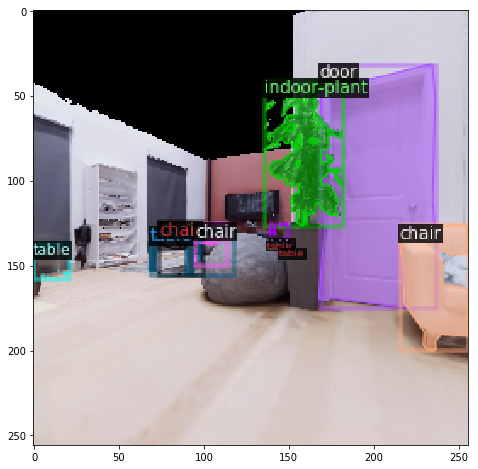

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/02645.jpg


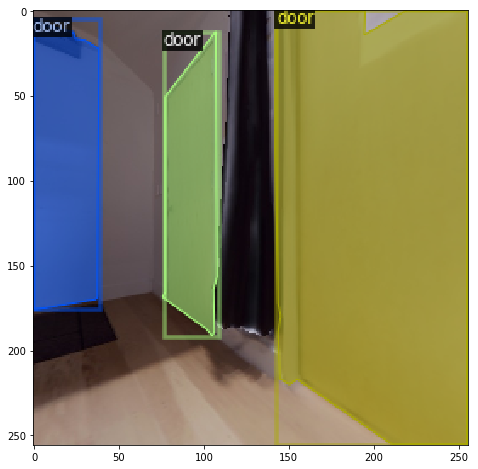

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/02900.jpg


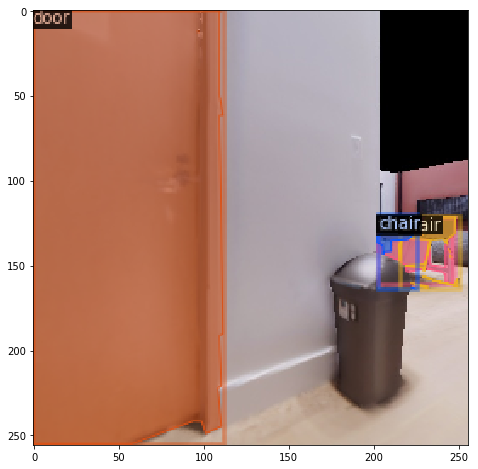

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04605.jpg


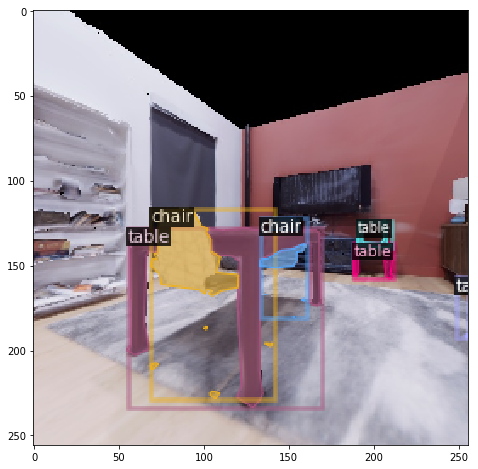

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04465.jpg


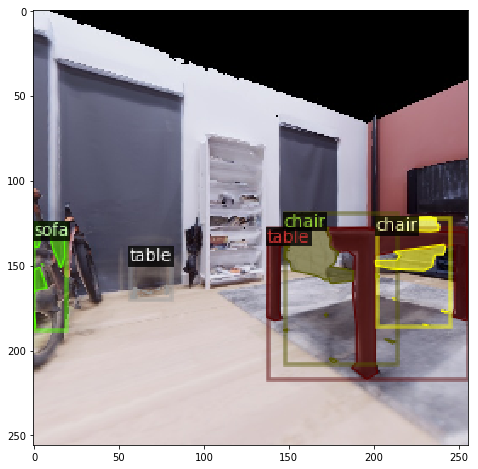

  0%|          | 1/355 [00:00<01:09,  5.09it/s]

Creating COCO annotations for 355 images 
 img_dir /checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb


100%|██████████| 355/355 [01:08<00:00,  5.19it/s]


Dumping annotations to frlapt1_20n1.json
1808 1808
/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/01295.jpg


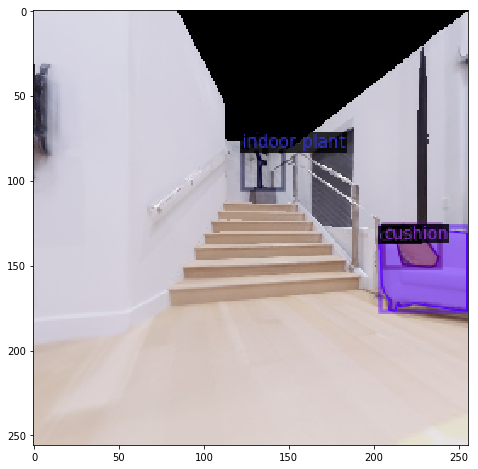

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/00400.jpg


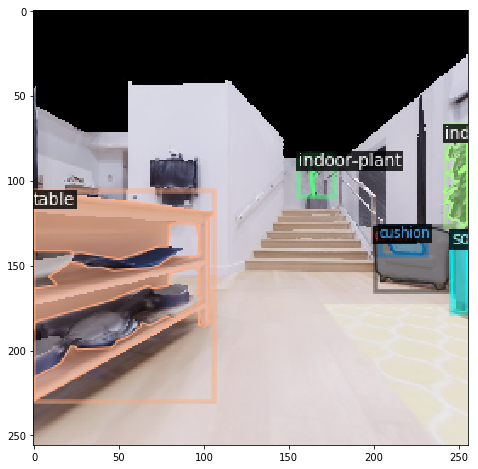

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/05065.jpg


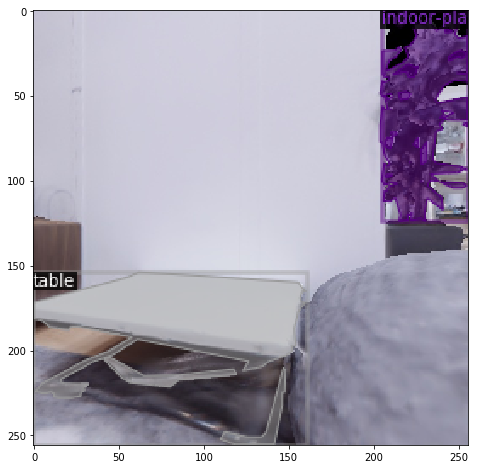

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04490.jpg


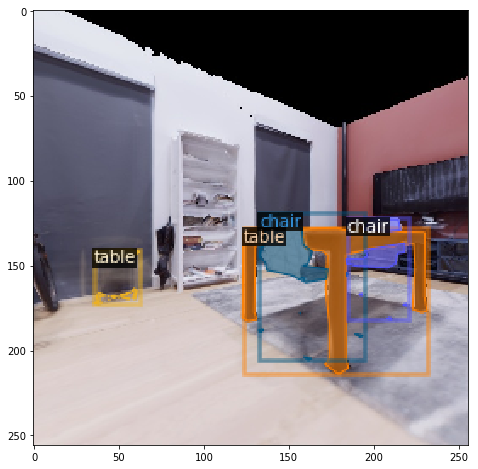

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04640.jpg


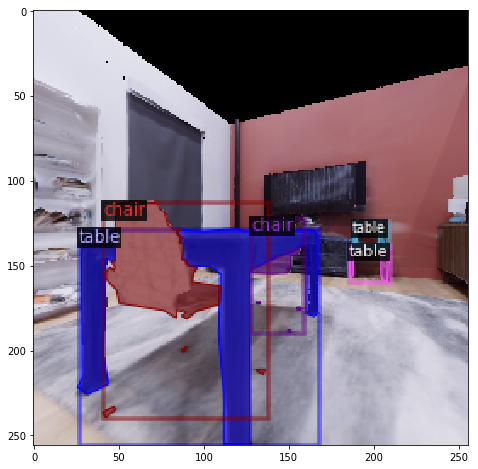

  0%|          | 1/355 [00:00<01:08,  5.15it/s]

Creating COCO annotations for 355 images 
 img_dir /checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb


100%|██████████| 355/355 [01:09<00:00,  5.13it/s]


Dumping annotations to frlapt1_20n2.json
1972 1972
/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/04250.jpg


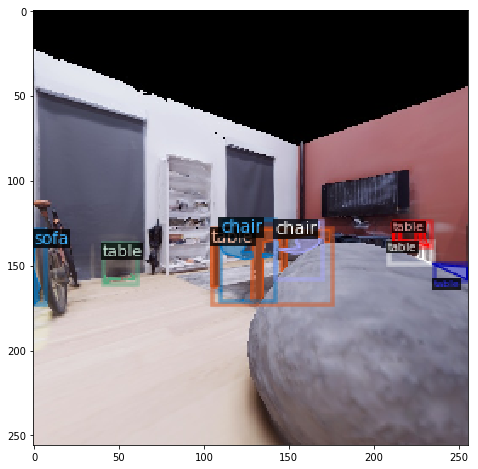

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/02280.jpg


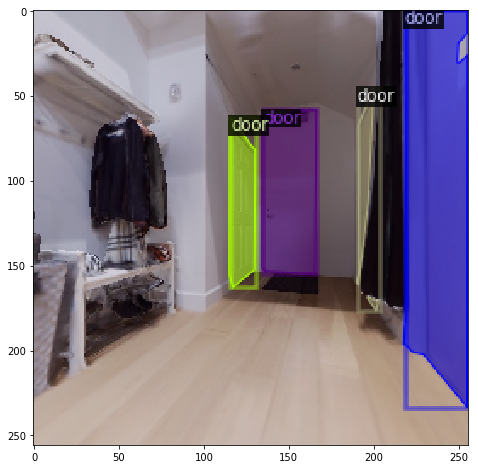

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/02600.jpg


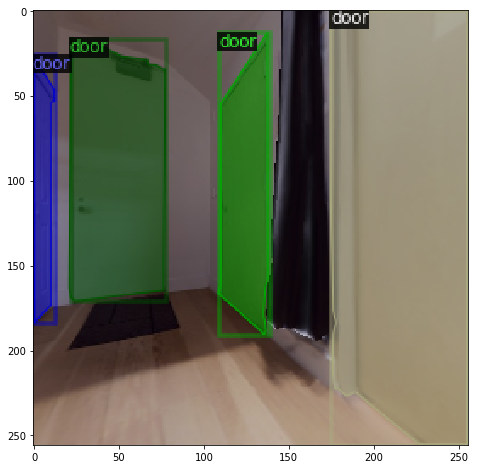

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/02780.jpg


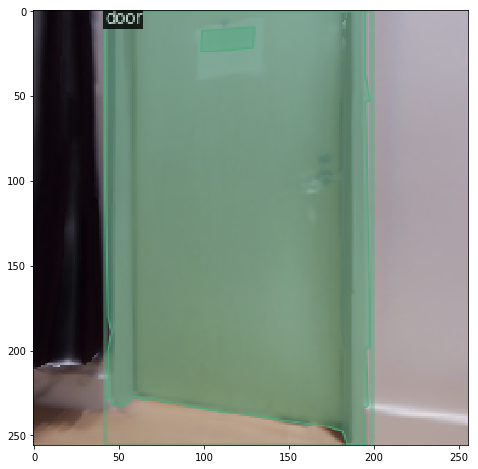

/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb/01220.jpg


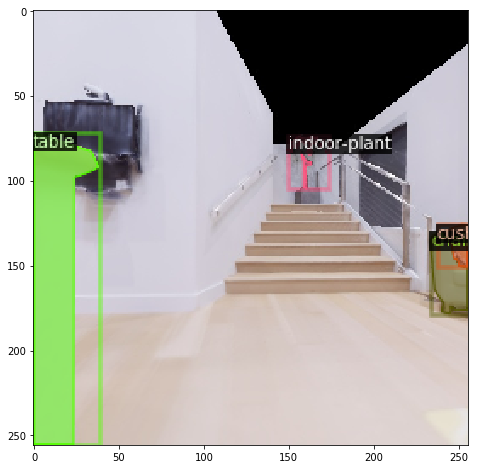

In [4]:
ctest = CocoCreator('/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data', semantic_json_root, labels)
ctest.create_coco('frl_apartment_1', 'frlapt1_20n', 'seg', 0.2, 3)